# Variational Auto Encoder

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper Parameters

In [3]:
batch_train = 256
batch_test = 128
epochs = 100
lr = 0.0001

## Load dataset

In [4]:
def load_dataset(anomaly, batch_train, batch_test):
    path = './data/mnist'
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    #import the original dataset
    orig_train_dataset = MNIST(path, train=True, download=True, transform=transform)
    orig_test_dataset = MNIST(path, train=False, download=True, transform=transform)

    #remove the anomaly from the train dataset
    idx = orig_train_dataset.train_labels != anomaly
    train_dataset = dataset.Subset(orig_train_dataset, np.where(idx==True)[0])
    #split the test set into normal and anomaly dataset
    idx = orig_test_dataset.test_labels != anomaly
    test_dataset = dataset.Subset(orig_test_dataset, np.where(idx==True)[0])
    anomaly_test_dataset = dataset.Subset(orig_test_dataset, np.where(idx==False)[0])

    #create dataloaders
    train_dl = DataLoader(train_dataset, batch_size=batch_train, shuffle=True, num_workers=12)
    test_dl = DataLoader(test_dataset, batch_size=batch_test, shuffle=False, num_workers=12, drop_last=True)
    anomaly_dl = DataLoader(anomaly_test_dataset, batch_size=batch_test, shuffle=False, num_workers=12, drop_last=True)

    return train_dl, test_dl, anomaly_dl

## Loss Function

In [5]:
def VAE_Loss(x, x_hat, mu, logvariance):
    '''
    The original reconstruction loss used by Kingma and Welling was the cross-entropy log(p(x|z)). 
    As p(x|z) ~ N(mu, sigma), the cross-entropy loss is proportional to the MSE loss between the input and the output.
    https://www.deeplearningbook.org/contents/ml.html (page 130)
    '''
    mse_loss = nn.functional.mse_loss(x, x_hat)
    '''
    The KL Divergence between N(mu, sigma) and N(0, 1) is 
    0.5 * sum_over_batch(1 + log(sigma^2) - mu^2 - sigma^2)
    For sigma values close to 0, the output of log(sigma^2) can explode
    Thus, we learn log(sigma^2) instead (logvariance)
    '''
    KL_loss = -0.5 * torch.sum(1 + logvariance - mu ** 2 - logvariance.exp())

    return KL_loss + mse_loss

## VAE

### Auxiliar Modules

In [6]:
class Conv_Cell(nn.Module):
    '''
    @input:
        input_size: number of filters of the input tensor
        n_filters: number of filters of the output tensor
    @output:
        tensor with size = (batch_size, n_filters, X.size()[2]/2, X.size()[3]/2)
    '''
    def __init__(self, input_size, n_filters):
        super(Conv_Cell, self).__init__()
        conv = nn.Conv2d(input_size, n_filters, kernel_size=3, stride=2, padding=1, bias=False)
        nn.init.xavier_uniform_(conv.weight)
        self.layers = nn.Sequential(
            conv,
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )

    def forward(self, X):
        return self.layers(X)

class Deconv_Cell(nn.Module):
    '''
    @input:
        input_size: number of filters of the input tensor
        n_filters: number of filters of the output tensor
    @output:
        tensor with size = (batch_size, n_filters, X.size()[2]*2, X.size()[3]*2)
    '''
    def __init__(self, input_size, n_filters):
        super(Deconv_Cell, self).__init__()
        deconv = nn.ConvTranspose2d(input_size, n_filters, kernel_size=4, stride=2, padding=1, bias=False)
        nn.init.xavier_uniform_(deconv.weight)
        self.layers = nn.Sequential(
            deconv,
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )

    def forward(self, X):
        return self.layers(X)

class Flatten(nn.Module):
    def forward(self, X):
        return X.view(X.size()[0], -1)

class Deflatten(nn.Module):
    '''
    @input:
        out_size: height/width of the output tensor
        n_filters: number of filters of the output tensor
    @output:
        tensor with size = (batch_size, n_filters, out_size, out_size)
    '''
    def __init__(self, out_size, n_filters):
        super(Deflatten, self).__init__()
        self.out_size = out_size
        self.n_filters = n_filters

    def forward(self, X):
        return X.view(X.size()[0], self.n_filters, self.out_size, -1)

### VAE Module

In [7]:
class VAE(nn.Module):
    def __init__(self, input_size=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential( #input 28x28x1
            Conv_Cell(input_size, 16), #outsize 14x14x16
            Conv_Cell(16, 32), #outsize 7x7x32
            Flatten() #outsize 1568
        )

        self.fc_mu = nn.Linear(1568, 100)
        self.fc_logvariance = nn.Linear(1568, 100)


        deconv = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False)
        nn.init.xavier_uniform_(deconv.weight)
        self.decoder = nn.Sequential(
            nn.Linear(100, 1568), #outsize 1568
            Deflatten(7, 32), #outsize 7x7x32
            Deconv_Cell(32, 16), #outsize 14x14x16
            deconv #outsize 28x28x1
        )

    def sample_latent_vector(self, mu, logvariance):
        samples = torch.randn_like(mu)
        samples.to(device)
        '''
        logvariance = log(sigma^2) -> sigma = exp(logvariance/2)
        '''
        return mu + samples * (torch.exp(0.5*logvariance))

    def forward(self, X):
        X = self.encoder(X)
        mu = self.fc_mu(X)
        logvariance = self.fc_logvariance(X)
        X = self.sample_latent_vector(mu, logvariance)
        X = self.decoder(X)
        return X, mu, logvariance

## Training

In [8]:
def train(train_dl, anomaly_dl):
    model = VAE()
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    _, (anomaly_fixed_test, labels) = enumerate(anomaly_dl).__next__()
    anomaly_fixed_test = anomaly_fixed_test.to(device)

    training_losses = []
    anomaly_losses = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
        total_loss=0.0
        anomaly_loss=0.0
        for i, data in enumerate(train_dl):
            x, labels = data
            x = x.to(device)
            #initialize gradients
            optimizer.zero_grad()
            #forward pass
            x_hat, mu, logvariance = model(x)
            #calculate loss
            loss = VAE_Loss(x, x_hat, mu, logvariance)
            #gradient descent
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        #check how the anomaly loss change during training
        with torch.no_grad():
            x_hat, mu, logvariance = model(anomaly_fixed_test)
            loss = VAE_Loss(anomaly_fixed_test, x_hat, mu, logvariance)
            anomaly_loss += loss.item()
        
        training_losses.append(total_loss/len(train_dl))
        anomaly_losses.append(anomaly_loss)

        tqdm.write(f'Loss: {total_loss/len(train_dl)} \t Anomaly Loss: {anomaly_loss}')
    return model, training_losses, anomaly_losses

In [9]:
#One class as anomaly, the others as normal classes
anomaly = 0
train_dl, test_dl, anomaly_dl = load_dataset(anomaly, batch_train, batch_test)
model0, training_losses0, anomaly_losses0 = train(train_dl, anomaly_dl)

Loss: 557.5276132619606 	 Anomaly Loss: 129.57960510253906
Loss: 109.00892041764169 	 Anomaly Loss: 62.81053161621094
Loss: 52.81355291042688 	 Anomaly Loss: 39.52474594116211
Loss: 32.180577287134135 	 Anomaly Loss: 28.43225860595703
Loss: 21.851064106203474 	 Anomaly Loss: 20.98085594177246
Loss: 15.859681171066356 	 Anomaly Loss: 16.575345993041992
Loss: 12.113861266172156 	 Anomaly Loss: 12.963626861572266
Loss: 9.569526935523411 	 Anomaly Loss: 10.77752685546875
Loss: 7.754750550917859 	 Anomaly Loss: 9.015608787536621
Loss: 6.408176191572873 	 Anomaly Loss: 7.467323303222656
Loss: 5.389531706301671 	 Anomaly Loss: 6.285504341125488
Loss: 4.578314807055132 	 Anomaly Loss: 5.40366268157959
Loss: 3.950356995159725 	 Anomaly Loss: 4.852651596069336
Loss: 3.433616339035754 	 Anomaly Loss: 3.9074459075927734
Loss: 2.99976291577771 	 Anomaly Loss: 3.613391876220703
Loss: 2.6590718593237535 	 Anomaly Loss: 3.3902816772460938
Loss: 2.3665042896315738 	 Anomaly Loss: 2.9283905029296875
Los

In [10]:
#One class as anomaly, the others as normal classes
anomaly = 1
train_dl, test_dl, anomaly_dl = load_dataset(anomaly, batch_train, batch_test)
model1, training_losses1, anomaly_losses1 = train(train_dl, anomaly_dl)

Loss: 559.3064655961032 	 Anomaly Loss: 112.01264190673828
Loss: 104.64131917223406 	 Anomaly Loss: 45.39693069458008
Loss: 50.10470102278239 	 Anomaly Loss: 26.82550811767578
Loss: 29.98896674790451 	 Anomaly Loss: 18.124019622802734
Loss: 19.959937585597974 	 Anomaly Loss: 14.081871032714844
Loss: 14.24108287192988 	 Anomaly Loss: 10.790105819702148
Loss: 10.702774009636144 	 Anomaly Loss: 8.489296913146973
Loss: 8.378751840888029 	 Anomaly Loss: 7.031154632568359
Loss: 6.757136885629317 	 Anomaly Loss: 6.0225629806518555
Loss: 5.561791486717297 	 Anomaly Loss: 5.23493766784668
Loss: 4.684574369608501 	 Anomaly Loss: 5.3041582107543945
Loss: 3.982354898344387 	 Anomaly Loss: 4.853211879730225
Loss: 3.4398706437012794 	 Anomaly Loss: 3.753061294555664
Loss: 2.9835439010670313 	 Anomaly Loss: 3.622626304626465
Loss: 2.6326535053230358 	 Anomaly Loss: 3.0300424098968506
Loss: 2.3224997795654825 	 Anomaly Loss: 2.887979030609131
Loss: 2.0743415956006666 	 Anomaly Loss: 2.600743293762207


In [11]:
anomaly = 0
train_dl = load_dataset(anomaly, batch_train, 512)[0]
mse_normal = 0.0
with torch.no_grad():
    for i, (x, label) in enumerate(train_dl):
        x = x.to(device)
        x_hat = model0(x)[0]
        mse = nn.functional.mse_loss(x, x_hat)
        mse_normal += mse.item()
    mse_normal /= len(train_dl)
print(mse_normal)

0.25728933801347353


In [12]:
anomaly = 1
train_dl = load_dataset(anomaly, batch_train, batch_test)[0]
mse_normal = 0.0
with torch.no_grad():
    for i, (x, label) in enumerate(train_dl):
        x = x.to(device)
        x_hat = model1(x)[0]
        mse = nn.functional.mse_loss(x, x_hat)
        mse_normal += mse.item()
    mse_normal /= len(train_dl)
print(mse_normal)

0.27684214026734016


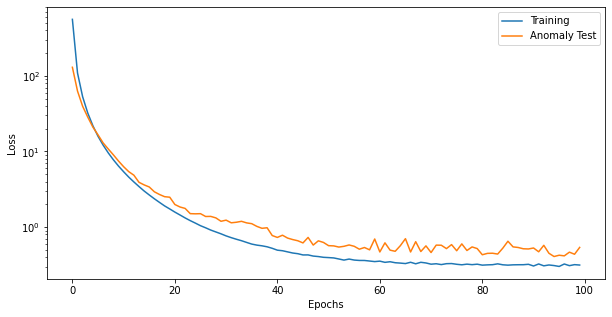

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(training_losses0, label='Training')
plt.plot(anomaly_losses0, label='Anomaly Test')
#to make easier to visualize the final loss
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

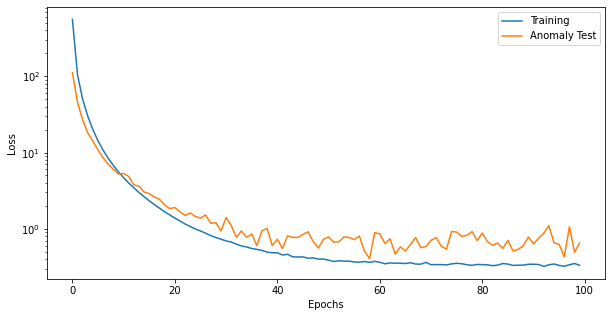

In [18]:
plt.figure(figsize=(10,5))
plt.plot(training_losses1, label='Training')
plt.plot(anomaly_losses1, label='Anomaly Test')
#to make easier to visualize the final loss
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

Using the reconstruction error as a classifier for now.

Might try implementing the reconstruction probability later. 
http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf

In [15]:
from sklearn.metrics import roc_auc_score
def calculate_auroc(model, anomaly, thresh):
    model.eval()
    model.to("cpu")
    _, normal_dl, anomaly_dl = load_dataset(anomaly, 1, 512)
    with torch.no_grad():
        y = np.empty(shape=(len(normal_dl)+len(anomaly_dl))*512)
        labels = np.empty(shape=(len(normal_dl)+len(anomaly_dl))*512)
        for i, (x, label) in enumerate(normal_dl):
            x_hat = model(x)[0]
            mse = np.square(x.numpy() - x_hat.numpy())
            mse = mse.reshape((mse.shape[0], -1)).mean(axis=1)
            y[i*512 : (i+1)*512] = (mse > thresh)
            labels[i*512 : (i+1)*512] = False
        offset = len(normal_dl)*512
        for i, (x, label) in enumerate(anomaly_dl):
            x_hat = model(x)[0]
            mse = np.square(x.numpy() - x_hat.numpy())
            mse = mse.reshape((mse.shape[0], -1)).mean(axis=1)
            y[offset+i*512 : offset+(i+1)*512] = (mse > thresh)
            labels[offset+i*512 : offset+(i+1)*512] = True
    return roc_auc_score(labels, y)


In [23]:
print(calculate_auroc(model0, 0, 0.3))

0.7393152573529412


In [17]:
print(calculate_auroc(model1, 1, 0.3))

0.3532858455882353


As expected, the digit 1 has a smaller auroc value. (similiar result was shown by An and Cho)